In [222]:
import json
import requests
import pandas as pd
import re
import plotly_express as px
from collections import  Counter
import datetime as dt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from api_funcs import connectAPI

### Load the dataframes from the APIs
1. Read configurations from config.ini
2. Use connectAPI class to gather data


In [201]:
# Connect to the Rick and Morty API and build dataframes
df_rm_character = connectAPI("RICKMORTYAPI",'character').get_results_df()
df_rm_episode = connectAPI("RICKMORTYAPI",'episode').get_results_df()

connected to https://rickandmortyapi.com/api/character
connected to https://rickandmortyapi.com/api/episode


In [202]:
# Connect to the Star Wars API and build dataframes
df_sw_films = connectAPI('SWAPI', 'films').get_results_df()
df_sw_people = connectAPI("SWAPI", 'people').get_results_df()

connected to https://swapi.dev/api/films
connected to https://swapi.dev/api/people


In [282]:
# clean up the gender column
df_sw_people['gender'][df_sw_people['gender']=='none'] = 'Genderless'
df_sw_people['gender'][df_sw_people['gender']=='n/a'] = 'Genderless'

df_rm_character['gender'] = df_rm_character["gender"].str.capitalize()
df_sw_people['gender'] = df_sw_people["gender"].str.capitalize()

### Total gender distributions: 
There is a significant and very similar gender inbalance in the data sets:

In [283]:
sw = pd.DataFrame(df_sw_people["gender"].value_counts()).reset_index()
rm = pd.DataFrame(df_rm_character["gender"].value_counts()).reset_index()

In [313]:
titles=["Character Genders in Star Wars", "Character Genders in Rick & Morty"]
dfs = [sw, rm]
for i in range(2):
    fig = px.pie(dfs[i], values="gender", names="index", 
                title=titles[i], 
                width=600, height=400)

    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=-0.5
    ))

    fig.show()

## Time evolution in gender distributions

1. Get the movie/episode specific gender distributions
2. Plot male and female values per episode/film

In [314]:
# Get gender from the character url
def get_gender(df, url_col, char_url):
    mask = df[url_col] == char_url
    return df[mask]['gender'].values[0]

# Adds total male and female counts to the film/episode tables
def add_counts(df_item, df_char):
    df_item['Male'] = 0
    df_item['Female'] = 0
    for row in df_item.iterrows():
        char_list = row[1].loc['characters']
        lst_gender = []
        for char in char_list:
            lst_gender.append(get_gender(df_char, 'url', char))
        c = Counter(lst_gender)
        df_item.loc[row[0], 'Male'] = c['Male']
        df_item.loc[row[0], 'Female'] = c['Female']
    return df_item

def plot_barchart(df, x_var, y_var, bar_title, x_tick_label):
    fig = px.bar(df, x=x_var, y=y_var, 
                labels={ "value":"Number of characters",
                        "variable":"Gender",
                        "Gender":y_var},
                )
    fig.update_layout(
        height=500,
        width =800,
        title_text = bar_title,
        xaxis = dict(
            tickmode = 'array',
            tickvals = df_sw_films[x_var],
            ticktext = [i[0]+', '+i[1] for i in zip( df[x_var], df[x_tick_label])]
        )
    )
    fig.show()

In [319]:
# clean up the release date
df_sw_films['Year'] = pd.to_datetime(df_sw_films['release_date']).dt.strftime('%Y')

In [322]:
df_sw_films = add_counts(df_sw_films, df_sw_people)

plot_barchart(df_sw_films, x_var = "Year", y_var=["Male", "Female"],
              bar_title = "Star Wars characters by gender in movies", x_tick_label = 'title' )

In [323]:
df_rm_episode = add_counts(df_rm_episode, df_rm_character)
df_rm_episode['Year'] = pd.to_datetime(df_rm_episode['air_date']).dt.strftime('%d-%m-%Y')

In [324]:
plot_barchart(df_rm_episode, 'Year', ["Male", "Female"], 
              bar_title = "Rick & Morty characters by gender per episode", x_tick_label='name')

In [343]:
df_rm_episode['Air Date'] = pd.to_datetime(arg = df_rm_episode['air_date'])

In [346]:
df_rm_datetime = df_rm_episode.groupby([df_rm_episode['Air Date'].dt.year,
                                        df_rm_episode['Air Date'].dt.month])[['Male', "Female"]].sum()

<AxesSubplot: xlabel='Air Date,Air Date'>

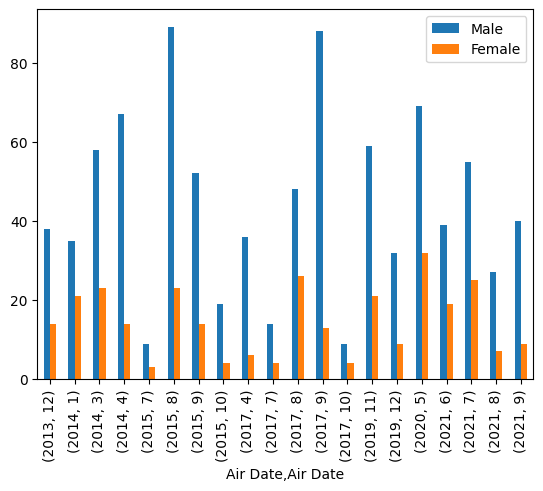

In [348]:
plot_barchart(df_rm_datetime, '', ["Male", "Female"], 
              bar_title = "Rick & Morty characters by gender per episode", x_tick_label='name')
#df_rm_datetime.plot(kind='bar')